# 회귀분석

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('font',family = 'Malgun Gothic')
plt.rc('axes',unicode_minus = False)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from scipy.stats import probplot
import scipy.stats as stats
import math
from scipy.stats import boxcox
import patsy
from sklearn.linear_model import Ridge,Lasso,ElasticNet

In [ ]:
boxcox(cars.Price)[0]

### 검토사항

1) 모형이 통계적으로 유의미한가?

2) F통계량 확인 -> 유의수준보다 작으면 통계적으로 유의하다

### 회귀계수들이 유의미한가?

1) 해당 계수의 t값과 p값 or 이들의 신뢰구간 확인

### 모형이 얼마나 설명력을 갖는가?

1) 결정계수 값 확인

### 잘 적합하고 있는가?

1) 잔차를 그래프로 그리고 회귀진단 실시

### 선형회귀분석 가정

1) y와 x는 선형관계이다.(선형성)

2) 오차항은 서로 독립이다.(독립성)

3) 오차항은 정규분포를 따른다.(정규성)
- 단순선형회귀분석 : 입력변수와 출력변수 간의 산점도 파악
- 다중선형에서는 잔차와 출력변수의 산점도 파악(가정이 모두 만족할 시에는 잔차는 랜덤하게 표현된다.)

4) 오차항은 분산은 동일하다.(등분산성)

## 1) 단순선형회귀분석

In [4]:
ad = pd.read_csv('Advertising.csv').iloc[:,1:]

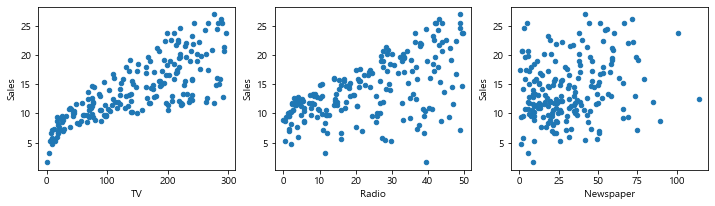

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
ad.plot.scatter('TV', 'Sales', ax = axes[0])
ad.plot.scatter('Radio', 'Sales', ax = axes[1] )
ad.plot.scatter('Newspaper', 'Sales', ax = axes[2] )
plt.show()

In [6]:
model = smf.ols("Sales ~ TV",data = ad).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Thu, 20 May 2021   Prob (F-statistic):           1.47e-42
Time:                        16:50:01   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.000       6.130       7.935
TV             0.0475      0.003     17.668      0.000       0.042       0.053
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.669
Skew:                          -0.089   Prob(JB):                        0.716
Kurtosis:                       2.779   Cond. No.                         338.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 추정된 회귀식 
$$ \hat y_i = \hat \beta_0 + \hat \beta_1 x_i $$

- $\hat y_i$: $x_i$ 값에 대한  $y_i$의 예측값 

- $\hat \beta_0, \hat \beta_1$: 계수추정치 

$\hat \beta_1$

     
#### 회귀계수의 해석
- 추정된 회귀식
$$ \hat y = 7.033 + 0.0475 x$$
- $\hat \beta_1$: TV광고 투자가 매 1천달러 증가할 경우 판매량은 47.5 유닛만큼 증가한다.
    
- $\hat \beta_0$: TV광고 투자가 0달러 일때 판매량은  7033 유닛이다(?!)  
    - $\beta_0$의 해석은 주의해야 함. 0이 데이터의 범위 안에 포함되는지 확인. 
     

### 1-1) 95% 신뢰구간

In [8]:
model.conf_int(alpha = 0.05)

,0,1
Intercept,6.129719,7.935468
TV,0.042231,0.052843


- 광고를 전혀하지 않으면 6130 ~ 7940 사이의 값으로 떨어진다.
- 광고 투자가 매 1천달러 증가하면 Tv는 42 ~ 53 사이만큼 증가한다.

### 1-2) 모델 정확도 평가

In [9]:
model.rsquared

0.611875050850071

In [12]:
stats.pearsonr(ad.Sales,ad.TV)[0] ** 2

0.6118750508500714

### 1-3) 예측

In [13]:
pred = model.get_prediction(exog=dict(TV = 100))
pred.summary_frame(alpha = 0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,11.786258,0.262897,11.26782,12.304695,5.339251,18.233264


#### 신뢰구간
- TV 광고에 10만달러 지출 시 판매량은 평균 11268개 ~ 12305사이일 것으로 95% 확신한다.

#### 예측구간

- 특정 도시의 판매량에 대한 불확실성을 수량화
- TV 광고에 10만달러 지출한 도시에서 판매량은 5339개 ~ 18233개 사이일 거승로 95%확신한다. 

## 2) 다중회귀분석

- EDA를 통해 상관관계 분석
- Summary를 통해 VIF 확인((Cond No) 확인하고, Warnings에 This might indicate that there are strong multicolinearity or other numerical problems라고 알려줌)
- 후에 vif 값 확인(vif 처리 방법 : vif 높은 값 제거, scale을 통해 낮추기, PCA를 통해 차원축소, 또는 변수선택법 진행)
- 
- 잔차분석 실시(선형성(잔차 그래프가 비선형 상관성이 있다면, log,루트, 제곱 등을 통해 변환), qqplot을 통해 정규성 확인(또한 정규성을 만족하지 않는다면 로그화 후 진행), 등분산성, 독립성(summary의 Durbin-Watson))
- 이상치 및 영향점 판단

In [14]:
model2 = smf.ols("Sales ~ Radio + Newspaper + TV",data = ad).fit()

In [16]:
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 20 May 2021   Prob (F-statistic):           1.58e-96
Time:                        17:03:23   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

$$ \hat y = 2.9389 + 0.1885 x_{1} - 0.001 x_{2} + 0.0458 x_{3} $$

### 2-1) F검정을 통한 모델의 유의성 평가
- $H_0$가 사실이면 $F=1$ 
- F=570에 대한 p-value가 0에 가까움: 광고매채 중 적어도 하나는 판매량 증가와 상관관계가 있다는 아주 강한 증거 

### 2-2) T검정을 이용한 회귀계수 검정

- TV와 Radio의 경우 p-value가 유의수준보다 작으므로 sales를 설명하는데 유의하다
- Newspaper의 경우 p-value가 유의수준보다 크므로 sales를 설명하는데 유의하지 않다.

- **TV와 라디오 광고의 경우 모형에 포함되어 있다면** 신문광고는 sales와 상관성이 없다고 결론을 내리게 된다.

In [17]:
model3 = smf.ols("Sales ~ Newspaper",data = ad).fit()
model3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


- Newspaper와 sales의 단순회귀모형에서는 회귀계수가 유의하다는 결과가 나온다.
- 신문광고에 의한 판매량이라고 보이는 것이 실제로는 라디오 광고에 의한 것


### 2-3) 예측

In [18]:
model4 = smf.ols('Sales ~ Radio + TV',data = ad).fit()

In [19]:
model4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9211,0.294,9.919,0.000,2.340,3.502
Radio,0.1880,0.008,23.382,0.000,0.172,0.204
TV,0.0458,0.001,32.909,0.000,0.043,0.048


In [20]:
pred= model4.get_prediction(exog = dict(TV = 100, Radio = 20))
pred.summary_frame(alpha = 0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,11.256466,0.137526,10.985254,11.527677,7.929616,14.583316



#### 신뢰구간 
    - 수많은 도시에 대한 평균 판매량을 둘러싼 불확실성을 수량화
    - TV광고에 10만달러, Radio광고에 2만달러를 지출한다면 판매량의 평균은 10985개와 11528개 사이일 것으로 95% 확신함

#### 예측구간
    - 특정 도시의 판매량에 대한 불확실성을 수량화
    - TV광고에 10만달러, Radio광고에 2만달러를 지출한 도시에서 판매량은 7930개와 14583개 사이일 것으로 95% 확신함  
  

## 3) 회귀진단

In [227]:
auto = pd.read_csv('auto.csv')

In [228]:
model_auto = smf.ols('mpg~horsepower', data = auto).fit()
model_auto.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,39.9359,0.717,55.660,0.000,38.525,41.347
horsepower,-0.1578,0.006,-24.489,0.000,-0.171,-0.145


 


### 3-1) 회귀모형의 잠재적 문제: 회귀진단 
#### 3-1-1)  데이터의 비선형성 
- 잔차그래프의 확인 
    - $e_i=y_i - \hat y_i$ vs. $x_i$ 의 그래프를 확인
    - 모델이 이상적이라면 인지할만한 패턴이 존재하지 않는다.
    - 잔차 그래프가 비선형 상관성이 있다면 $\log X, \sqrt X, X^2$과 같이 설명변수들을 비선형적으로 변환하여 회귀모델에 적용하는 것이 간단한 접근법 
        

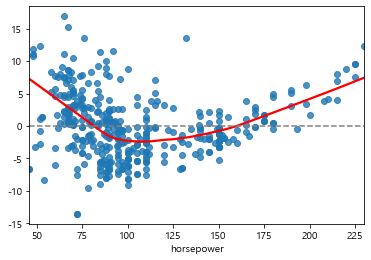

In [229]:
sns.regplot(auto.horsepower,model_auto.resid,lowess=True, line_kws={'color' :'red'})
plt.plot([auto.horsepower.min(),auto.horsepower.max()],[0,0],'--',color=  'grey')
plt.show()

- 2차 함수로 보이기에 루트를 씌워주어서 선형적으로 만든다

In [230]:
model_auto2 = smf.ols("mpg ~ horsepower + np.square(horsepower)",data = auto).fit()
model_auto2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
np.square(horsepower),0.0012,0.000,10.080,0.000,0.001,0.001


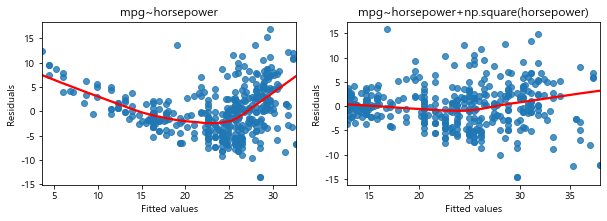

In [231]:
plt.figure(figsize=(10, 3))

plt.title('mpg~horsepower')
plt.subplot(1,2,1)
sns.regplot(model_auto.fittedvalues,model_auto.resid,lowess=True,line_kws={'color' : "red"})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('mpg~horsepower')

plt.subplot(1,2,2)
sns.regplot(model_auto2.fittedvalues,model_auto2.resid,lowess=True,line_kws={'color' : "red"})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('mpg~horsepower+np.square(horsepower)')
plt.show()

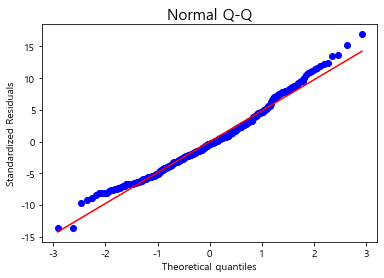

In [232]:
probplot(model_auto.resid,plot = plt)
plt.ylabel('Standardized Residuals')
plt.title("Normal Q-Q",fontsize = 15)
plt.show()

### 3-1-2) 오차항의 상관성 
- 선형모델의 가정: 오차항 $\epsilon_1, \epsilon_2, \ldots, \epsilon_n$이 서로 상관되어 있지 않다는 것 
- 오차항 사이에 상관성이 있으면 추정된 표준오차는 실제 표준오차를 과소추정하는 경향이 발생한다.
    - 계산된 95% 신뢰구간과 예측구간이 실제 모수를 포함할 가능성이 95%보다 낮을 수 있다. 
    - 모수가 통계적으로 유의하다 잘못된 결론을 내릴 수 있다.

- 시계열 데이터에서 자주 발생 
    - 잔차를 시간의 함수로 그렸을 때 인지할 만한 패턴이 없어야 한다. 

In [233]:
durbin_watson(model_auto2.resid)

1.0782139387132903

- 값이 2와 가까우면 자기 상관성이 없다(독립이다)
- 값이 0과 가까우면 positive serial correlation
- 값이 4와 가까우면 negative serial correlation
- 값이 0과 4에 가까우면 자기상관이 존재하는 것이며 이 경우 회귀분석을 할 수 없고, data 수를 추가하거나 중요한 독립변수를 추가하는 방법을 사용한다. 이 방법으로도 해결되지 않을 경우 시계열 분석을 실시한다.

### 3-1-3) 오차항의 이분산성 
- 선형모델의 가정: $Var(\epsilon_i)= \sigma^2$
- 잔차그래프에 깔때기 형태가 있는지 보고 식별 

#### 종속변수의 변환
- 예를 들면, $log(y)$한 뒤 회귀식을 적합

<img src='http://drive.google.com/uc?export=view&id=1qWMJojwzeKfbWmlayeeJogaIk46es9QD' width=500 /><br>    

In [235]:
model_auto3 = smf.ols('np.log(mpg) ~ horsepower + np.square(horsepower)',data = auto).fit()

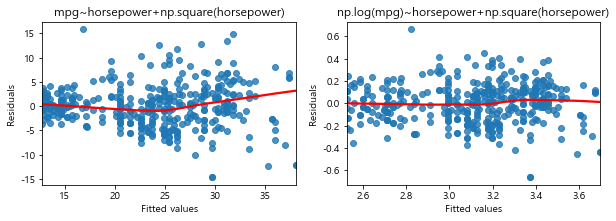

In [236]:
plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
sns.regplot(model_auto2.fittedvalues,model_auto2.resid,lowess=True,line_kws={'color' : "red"})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('mpg~horsepower+np.square(horsepower)')
plt.subplot(1,2,2)
sns.regplot(model_auto3.fittedvalues,model_auto3.resid,lowess=True,line_kws={'color' : "red"})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('np.log(mpg)~horsepower+np.square(horsepower)')
plt.show()

### 3-1-4) 이상치
- |스튜던트화 잔차| > 3이면 이상치라고 판정한다

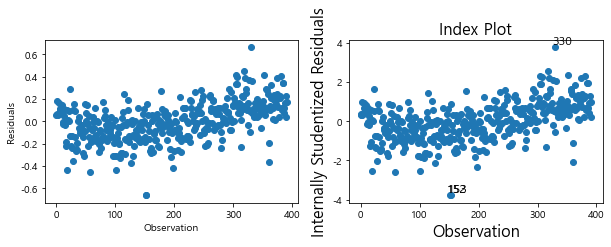

In [237]:
inf3 = OLSInfluence(model_auto3)
fig, ax = plt.subplots(1,2, figsize=(10, 3))
ax[0].scatter(auto.index,model_auto3.resid)
ax[0].set_xlabel('Observation')
ax[0].set_ylabel('Residuals')
inf3.plot_index('resid',threshold=3, ax = ax[1]) ## 스튜던트화 잔차 3 이상(threshold =3)
plt.show()

- 이상치 처리?
    - 이상치가 수집 또는 기록에 의한 오류에 의해 발생하였다면 관측치를 제외
    - 필요 설명변수가 없는 것과 같은 모델의 결함을 나타낼 수 있으므로 주의 

### 3-1-5) 영향점

- 영향점은 추정회귀선에 영향을 많이 주는 관측치이다.


#### 레버리지(leverage) 통계량
- 단순회귀분석의 경우 
$$ h_i = \frac 1 n + \frac {(x_i - \bar x)^2 }{\sum_{i'} (x_{i'} - \bar x )^2 }$$
-  $x_i$값이 $\bar x$에서 멀리 떨어져 있을 수록 레버리지 값이 크다.
- $h_i$의 평균은 $(p+1)/n$
- 레버리지와 residual이 동시에 크면 추정회귀선에 큰 영향을 준다. 

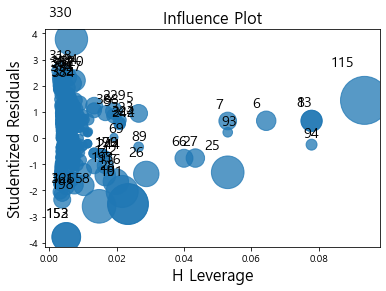

In [22]:
inf3.plot_influence()
plt.show()

Text(0, 0.5, 'Standardized Residuals')

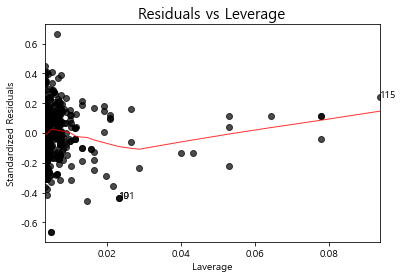

In [23]:
plt.scatter(model_auto3.get_influence().hat_matrix_diag, model_auto3.resid, color = 'black', alpha = .7)
sns.regplot(model_auto3.get_influence().hat_matrix_diag, model_auto3.resid,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
leverage_top_3 = np.flip(np.argsort(model_auto3.get_influence().cooks_distance[0]), 0)[:3]
for i in leverage_top_3:
    plt.annotate(i, xy=(model_auto3.get_influence().hat_matrix_diag[i],
                                 model_auto3.resid[i]));
plt.title('Residuals vs Leverage', size = 15)
plt.xlabel('Laverage')
plt.ylabel("Standardized Residuals")

### 3-1-6) Cook's Distance

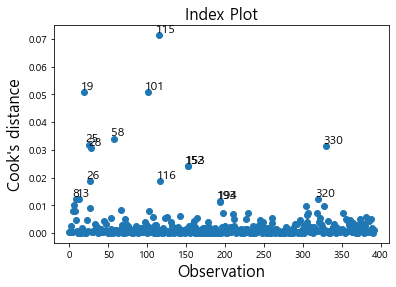

In [25]:
inf3.plot_index('cook',threshold=4 / (model_auto3.nobs-2-1))
plt.show()

In [32]:
cd,_ = inf3.cooks_distance
cd.sort_values(ascending = False).head()

115    0.071346
101    0.050754
19     0.050754
58     0.034025
25     0.031907
dtype: float64

- 쿡의 거리가 기준값인 1보다 클 경우에 영향치로 간주
- 거의 모든 값이 0.05보다 작거나 비슷하기에 대부분 자료가 예측에서 크게 벗어나지 않았다고 할 수 있다.

#### DFBETAS
- 각각의 Data를 제거시 포함시의 회귀 계수의 차이
- 각 데이터(행별)로 표시됨
- 이상값 기준: 다른 행의 dfbeta 대비 얼마나 커야하는가?
- 기준 값은 2 혹은 2/표본수의 제곱근

In [239]:
OLSInfluence(model_auto3).dfbetas

array([[-0.01639029,  0.01751962, -0.01592291],
       [-0.01106963,  0.00909162, -0.0035559 ],
       [-0.0481316 ,  0.04716208, -0.03664258],
       ...,
       [ 0.01254701,  0.00089547, -0.00739394],
       [ 0.00506329, -0.00271123,  0.00139797],
       [ 0.01477426, -0.00434091, -0.00102117]])

#### DFFITS
- i번째 관측치 제외 시 종속변수 예측치의 변화 정도
- 기준치는 2 * ((상수항을 포함한 변수의 수 + 1) / 표본의수)의 제곱근

In [241]:
OLSInfluence(model_auto3).dffits

(0      0.024266
 1      0.036085
 2      0.087113
 3      0.029013
 4      0.029319
          ...   
 387    0.024736
 388    0.123493
 389    0.073792
 390    0.013188
 391    0.057371
 Length: 392, dtype: float64,
 0.1749635530559413)

### 3-1-7) 다중공선성

- 설명변수들(독립변수) 사이에 선형관계가 존재하면 회귀계수의 정확한 추정이 불가
- VIF(분산팽창인수)를 통해 공선성을 알 수 있다.
        - 가능한 가장 작은 값=1: 공선성이 전혀 없음
        - VIF가 5 또는 10을 초과하면 공선성 존재한다고 경험적으로 판단 

In [36]:
credit = pd.read_csv('Credit.csv').iloc[:,1:]

In [37]:
model_credit = smf.ols('Balance~Age+Limit', data = credit).fit()
model_credit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-173.4109,43.828,-3.957,0.000,-259.576,-87.246
Age,-2.2915,0.672,-3.407,0.001,-3.614,-0.969
Limit,0.1734,0.005,34.496,0.000,0.163,0.183


In [38]:
model_credit2 = smf.ols('Balance~Rating+Limit', data = credit).fit()
model_credit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-377.5368,45.254,-8.343,0.000,-466.505,-288.569
Rating,2.2017,0.952,2.312,0.021,0.330,4.074
Limit,0.0245,0.064,0.384,0.701,-0.101,0.150


In [39]:
model_credit3 = smf.ols('Balance~Age+Rating+Limit', data = credit).fit()
import patsy
y, X = patsy.dmatrices('Balance~Age+Rating+Limit', credit, return_type='matrix')

from statsmodels.stats.outliers_influence import variance_inflation_factor
for i, x in enumerate(X.design_info.column_names):
    print( 'VIF of', x, ':', variance_inflation_factor(X, i))

VIF of Intercept : 23.80295451367821
VIF of Age : 1.0113846860681328
VIF of Rating : 160.66830095856935
VIF of Limit : 160.59287978597942


- Rating과 Limit는 다중공선성이 존재한다고 할 수 있다.



- 공선성의 해결
    - 문제가 있는 변수들 중의 하나를 제거 
        - 회귀적합에 별로 나쁜 영향을 주지 않음 
    - 변수선택 방법 사용 
    - 공선성 변수들을 단일 설명변수로 결합 
        - 새로운 변수 생성
        - 주성분분석 활용 
        

- 표준화(정규화)한 후 회귀분석 결과 해석 -> 다른 독립변수가 고정일 시 a 1표준편차 증가할 때 y의 증가량이라고 설명한다.

## 예제

In [43]:
house  = pd.read_csv('houseprice.csv')

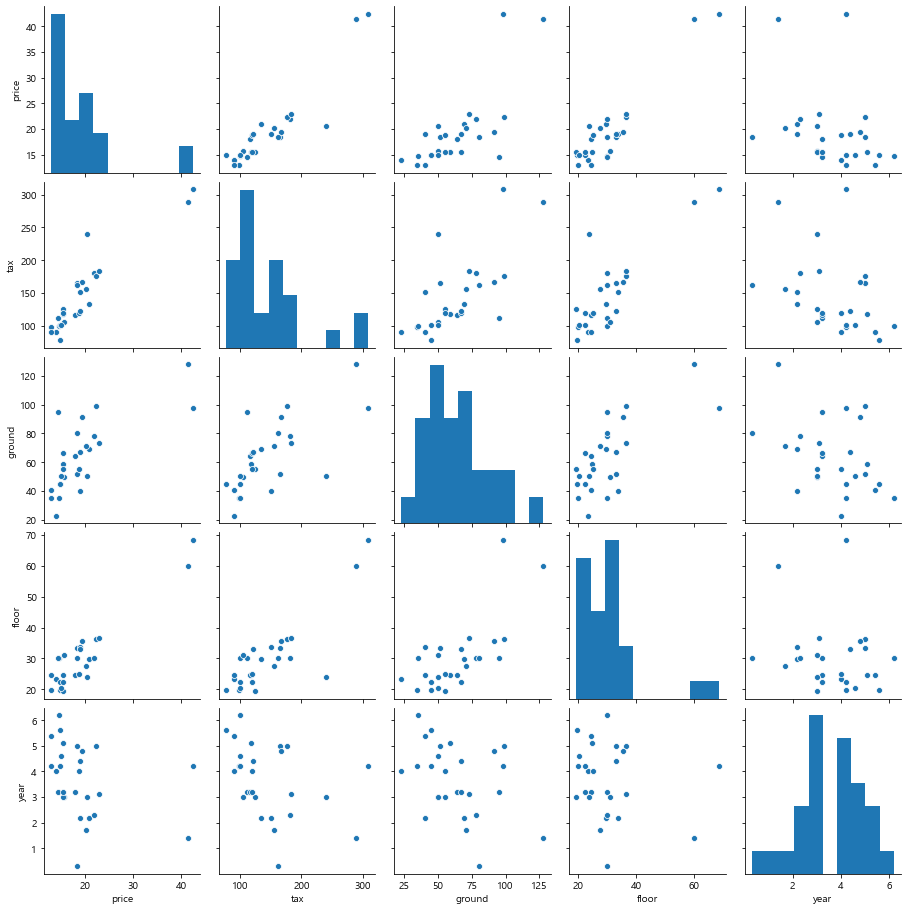

In [45]:
sns.pairplot(house)
plt.show()

In [46]:
model = smf.ols('price ~ tax+ground+floor+year', data=house).fit()

In [47]:
model.rsquared

0.9312715052594145

In [49]:
durbin_watson(model.resid)

1.9003462982403567

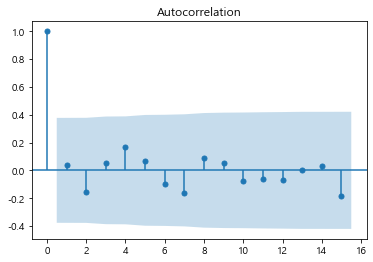

In [50]:
sm.graphics.tsa.plot_acf(model.resid)
plt.show()

## 4) 범주형 설명변수

### 4-1) 레벨 수가 2인 범주형 변수

In [56]:
credit = pd.read_csv('Credit.csv').iloc[:,1:]


- 두 개의 가능한 값을 가지는 indicator variable (dummy variable)을 생성 
$$ d_i  = \left\{ \begin{matrix}
1 & i \mbox{번째 사람이 학생인 경우} \\
0 & i \mbox{번째 사람이 학생이 아닌 경우}
\end{matrix}
\right.$$

- 이 변수를 설명변수로 한 회귀식 
$$ y_i = \beta_0 + \beta_1 d_i + \epsilon_i$$

$$ y_i = \left\{ \begin{matrix}
\beta_0 + \beta_1 +\epsilon_i   & i \mbox{번째 사람이 학생인 경우} \\
\beta_0 + \epsilon_i  & i \mbox{번째 사람이 학생이 아닌 경우}
\end{matrix}
\right.$$

- $\beta_0$: 학생이 아닌 사람의 평균 신용카드 대금
- $\beta_0+ \beta_1$: 학생의 평균 신용카드 대금 
- $\beta_1$: 학생과 학생이 아닌 사람의 평균 신용카드 대금의 차이 

In [57]:
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


- 이 때 기준이 되는  __reference level__ 은 무엇인가?
   - 기준: Student = No인 그룹
   - 기준이 되는 level의 평균 balance: $\beta_0$
   - 기준이 되는 level에 비해 다른 level의 평균 balance가 얼만큼 큰가?: $\beta_1$
   - $\beta_0$ : 학생이 아닌 사람의 평균 신용카드 대금
   - $\beta_0$ + $\beta_1$ : 학생의 평균 신용카드 대금
   - $\beta_1$ : 학생과 학생이 아닌 사람의 평균 신용카드 대금의 차이

In [58]:
model = smf.ols("Balance ~ Student",data = credit).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,480.3694,23.434,20.499,0.000,434.300,526.439
Student[T.Yes],396.4556,74.104,5.350,0.000,250.771,542.140


  
- $H_0: \beta_1=0$ 
    - "학생과 학생이 아닌 사람의 평균 신용카드 대금의 차이가 없다"라는 귀무가설 
    - p-value<0.05 이므로 두 집단 간의 유의한 통계적인 차이가 있다고 결론 
   

In [62]:
y,X = patsy.dmatrices('Balance ~ Student', data = credit, return_type='dataframe')
X.head()

,Intercept,Student[T.Yes]
0,1.0,0.0
1,1.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


### 4-2) 레벨 수가 3 이상인 범주형 설명변수 
- Ethnicity: 백인, 흑인, 아시아인 (레벨이 3개)
- 2개의 dummy variable 생성

$$ d_{1i}  = \left\{ \begin{matrix}
     1 & i \mbox{번째 사람이 아시아인 경우} \\
     0 & i \mbox{번째 사람이 아시아인이 아닌 경우 }
     \end{matrix}
     \right.$$
     
$$ d_{2i}  = \left\{ \begin{matrix}
     1 & i \mbox{번째 사람이 백인인 경우} \\
     0 & i \mbox{번째 사람이 백인이 아닌 경우 }
     \end{matrix}
     \right.$$
- 이 경우 reference level은 무엇인가?

- 이 변수를 설명변수로 한 각 그룹의 회귀식 
$$ y_i = \beta_0 + \beta_1 d_{1i} + \beta_2 d_{2i}  + \epsilon_i $$

$$ y_i = \left\{ \begin{matrix}
    \beta_0 + \beta_1 +\epsilon_i   & i \mbox{번째 사람이 아시아인인  경우} \\
    \beta_0 + \beta_2+ \epsilon_i  & i \mbox{번째 사람이 백인인  경우}\\
    \beta_0 + \epsilon_i  & i \mbox{번째 사람이 흑인인   경우}\\
    \end{matrix}
    \right.$$

    

In [63]:
model2 = smf.ols("Balance ~ Ethnicity",data = credit).fit()
model2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


In [65]:
model3 = smf.ols('Balance ~ C(Ethnicity, Treatment(reference = "Asian"))',data = credit).fit()
model3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,512.3137,45.632,11.227,0.000,422.602,602.025
"C(Ethnicity, Treatment(reference=""Asian""))[T.African American]",18.6863,65.021,0.287,0.774,-109.142,146.515
"C(Ethnicity, Treatment(reference=""Asian""))[T.Caucasian]",6.1838,56.122,0.110,0.912,-104.149,116.517


In [66]:
y, X1 = patsy.dmatrices('Balance ~ Ethnicity', data = credit, return_type = "dataframe")
y, X2 = patsy.dmatrices('Balance ~ C(Ethnicity, Treatment(reference = "Asian")) ', data = credit, return_type="dataframe")

In [68]:
X1.head()

,Intercept,Ethnicity[T.Asian],Ethnicity[T.Caucasian]
0,1.0,0.0,1.0
1,1.0,1.0,0.0
2,1.0,1.0,0.0
3,1.0,1.0,0.0
4,1.0,0.0,1.0


### 4-3) 범주형 + 연속형 설명변수

In [72]:
model4 = smf.ols("Balance ~ Income + Student",data = credit).fit()
model4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,211.1430,32.457,6.505,0.000,147.333,274.952
Student[T.Yes],382.6705,65.311,5.859,0.000,254.272,511.069
Income,5.9843,0.557,10.751,0.000,4.890,7.079


- `Student[T.Yes]`의 계수(382.67): Income이 동일한 수준일 때 학생과 학생 아닌 사람의 평균 신용카드 대금의 차이
    
- `Income`의 계수(5.98): Income이 1 증가할 때  Balance는 5.98 증가한다. (Student/non-student 공통) 

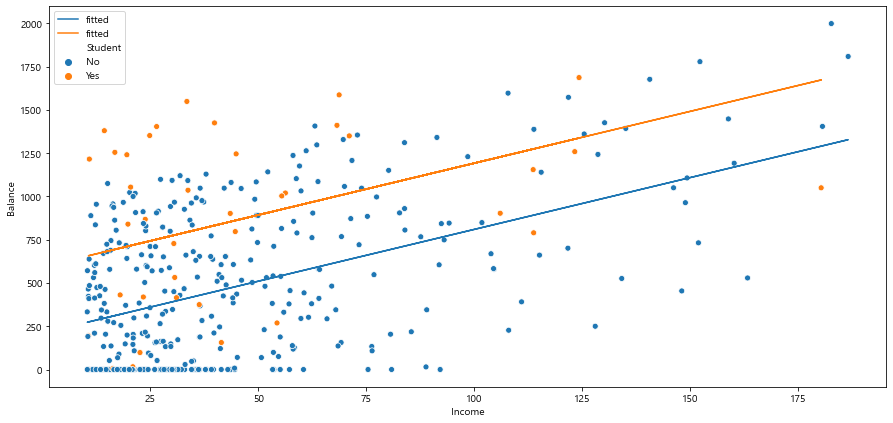

In [73]:
credit['fitted'] = model4.fittedvalues

fig, ax = plt.subplots(figsize=(15,7))

credit.groupby('Student').plot(x='Income', y='fitted', 
                               ax=ax, legend=False)
sns.scatterplot(x= "Income", y="Balance", data=credit, hue="Student")
plt.show()

### 부분 F검정
- 두 모형이 유의미한 차이가 있는지 알아보기 위해 사용하는 방법으로 만약 차이가 없다면 모수 절약의 원칙으로 모수가 적은 모형을 선택한다.
- F통계량이 작으면 빠진 설명변수가 없어도 괜찮다.
- F통계량이 크면 빠진 설명변수의 설명력이 크다고 할 수 있다.

In [74]:
from statsmodels.stats.anova import anova_lm
model5 = smf.ols('Balance ~ Income + Student + Ethnicity ', data = credit).fit()
model5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,206.7655,47.992,4.308,0.000,112.413,301.117
Student[T.Yes],384.2829,65.569,5.861,0.000,255.376,513.190
Ethnicity[T.Asian],-7.9309,55.464,-0.143,0.886,-116.973,101.111
Ethnicity[T.Caucasian],12.4020,48.338,0.257,0.798,-82.629,107.433
Income,5.9859,0.558,10.721,0.000,4.888,7.084


In [75]:
anova_lm(model4, model5)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2007: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,397.0,6.093905e+07,0.0,NaN,NaN,NaN
1,395.0,6.090901e+07,2.0,30047.507138,0.09743,0.907187


- F통계량도 작은 값을 가지고 있고 이에 대한 p-value도 0.05보다 크므로 귀무가설을 채택하게 된다. 즉 빠진 설명변수가 없어도 괜찮으므로 model4 모형을 선택한다.

### 4-4) Effect Coding
- 경우에 따라 특정 level을 기준으로 비교하기 보다는 모든 집단의 평균으로부터 각 집단이 평균의 유의한 차이를 보이는지가 궁금할 수 있다.
- Design matrix를 어떻게 구성하면 좋을까?

$$ d_i  = \left\{ \begin{matrix}
1 & i \mbox{번째 사람이 학생이 아닌 경우} \\
-1 & i \mbox{번째 사람이 학생인 경우}
\end{matrix}
\right.$$

$$ y_i = \beta_0 + \beta_1 d_i + \epsilon_i $$
$$ y_i = \left\{ \begin{matrix}
\beta_0 + \beta_1 +\epsilon_i   & i \mbox{번째 사람이 학생이 아닌 경우} \\
\beta_0 - \beta_1 + \epsilon_i  & i \mbox{번째 사람이 학생인 경우}
\end{matrix}
\right.$$

- $\beta_0$: 학생 여부를 고려하지 않은 전체 평균 신용카드 대금
- $\beta_1$: 학생들은 평균보다 높고 학생이 아닌 사람들은 평균보다 낮은 신용카드 대금의 양 


In [76]:
model5 = smf.ols('Balance ~ Income + C(Student, Sum)', data = credit).fit()
model5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,402.4782,41.540,9.689,0.000,320.812,484.144
"C(Student, Sum)[S.No]",-191.3353,32.655,-5.859,0.000,-255.534,-127.136
Income,5.9843,0.557,10.751,0.000,4.890,7.079


- 학생이 아닌 그룹이 전체평균보다 191만큼 Balance가 평균적으로 작다

In [77]:
y, X = patsy.dmatrices('Balance ~ Income + C(Student, Sum)', data=credit, return_type = "dataframe")
X.head()

,Intercept,"C(Student, Sum)[S.No]",Income
0,1.0,1.0,14.891
1,1.0,-1.0,106.025
2,1.0,1.0,104.593
3,1.0,1.0,148.924
4,1.0,1.0,55.882


### 4-5) 교호작용

In [78]:
ad=pd.read_csv("Advertising.csv")
model_ad = smf.ols('Sales~TV+Radio+TV*Radio', data = ad).fit()
model_ad.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


- 교호작용항이 유의하지만 주효과(main effect: 여기서는 TV와 radio)가 유의하지 않은 경우 주효과를 제거해야 하는가?
    - 계층적 원리에 의해 교호작용을 포함하면  주효과가 유의하지 않더라도 모델에 포함 
    - $X_1 \times X_2$가 유의하면 $X_1$, $X_2$의 각 계수가 0인지는 관심 없음 
    - 주효과를 제외하면 교호작용의 의미를 바꾸는 경향이 있음 

### 범주형 X 연속형(교호작용)

In [79]:
model6 = smf.ols('Balance~(Income+Student)**2', data = credit).fit()
model6.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,200.6232,33.698,5.953,0.000,134.373,266.873
Student[T.Yes],476.6758,104.351,4.568,0.000,271.524,681.827
Income,6.2182,0.592,10.502,0.000,5.054,7.382
Income:Student[T.Yes],-1.9992,1.731,-1.155,0.249,-5.403,1.404


- 교호작용 항이 통계적으로 유의미하지 않으므로 기울기가 다르지 않다고 결론

## 5) 변수선택 방법

### 5-1) 최상의 부분집합 선택

- AIC, BIC
    - 작은 오차를 가지는 모델들이 작은 값을 가지는 경향
    - 변수의 개수에 대한 패널티 부여
    - 각 기준으로 가장 낮은 값을 가지는 모형 선택
    - BIC가 더 작은 크기의 모델이 선택되는 경향
-  Adjusted $R^2$
    - 클 수록 오차가 작은 모델
    - 올바른 변수들이 모두 모델에 포함되고 나면 불필요한 변수의 추가로 얻는 RSS 감소는 미세한 반면 변수 개수 추가에 의한 패널티 값이

In [83]:
import patsy
y, X = patsy.dmatrices('Balance~'+"+".join(credit.columns[:-1]), data = credit, return_type='dataframe')

In [90]:
X = X.iloc[:,:-1]

In [85]:
import itertools
import time
import statsmodels.api as sm

def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    X_model = X[list(('Intercept',)+feature_set)]
    model = sm.OLS(y, X_model)
    regr = model.fit()
    RSS = (regr.resid ** 2).sum()
    return {"model":regr, "RSS":RSS, "AIC": regr.aic, 
            "BIC": regr.bic, "adj_r2": regr.rsquared_adj,
           "r2":regr.rsquared }

def getBest(k, best = "AIC"):
    
    tic = time.time()   
    results = []
    
    for combo in itertools.combinations(X.columns[1:], k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    if best=="adj_r2" or best=="r2":
        best_model = models.loc[models[best].argmax()]
    else: 
        best_model = models.loc[models[best].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [91]:
models_best = pd.DataFrame(columns=["model", "RSS","AIC","BIC","adj_r2", "r2"])

for i in range(1,X.shape[1]-1):
    models_best.loc[i] = getBest(i, best = "AIC")

Processed 11 models on 1 predictors in 0.01597452163696289 seconds.
Processed 55 models on 2 predictors in 0.061864376068115234 seconds.
Processed 165 models on 3 predictors in 0.17752575874328613 seconds.
Processed 330 models on 4 predictors in 0.350064754486084 seconds.
Processed 462 models on 5 predictors in 0.5216052532196045 seconds.
Processed 462 models on 6 predictors in 0.5086915493011475 seconds.
Processed 330 models on 7 predictors in 0.3614015579223633 seconds.
Processed 165 models on 8 predictors in 0.17848944664001465 seconds.
Processed 55 models on 9 predictors in 0.07679486274719238 seconds.
Processed 11 models on 10 predictors in 0.013961315155029297 seconds.


In [92]:
models_best

,model,RSS,AIC,BIC,adj_r2,r2
1,<statsmodels.regression.linear_model.Regressio...,2.143512e+07,5494.781548,5502.764477,0.745210,0.745848
2,<statsmodels.regression.linear_model.Regressio...,1.053254e+07,5212.557085,5224.531479,0.874489,0.875118
3,<statsmodels.regression.linear_model.Regressio...,4.227219e+06,4849.386992,4865.352851,0.949499,0.949879
4,<statsmodels.regression.linear_model.Regressio...,3.915058e+06,4820.701337,4840.658660,0.953110,0.953580
5,<statsmodels.regression.linear_model.Regressio...,3.866091e+06,4817.666820,4841.615607,0.953579,0.954161
6,<statsmodels.regression.linear_model.Regressio...,3.821620e+06,4815.038963,4842.979215,0.953996,0.954688
7,<statsmodels.regression.linear_model.Regressio...,3.810759e+06,4815.900560,4847.832276,0.954010,0.954817
8,<statsmodels.regression.linear_model.Regressio...,3.804746e+06,4817.268900,4853.192081,0.953965,0.954888
9,<statsmodels.regression.linear_model.Regressio...,3.798367e+06,4818.597738,4858.512384,0.953924,0.954964
10,<statsmodels.regression.linear_model.Regressio...,3.791345e+06,4819.857603,4863.763713,0.953891,0.955047


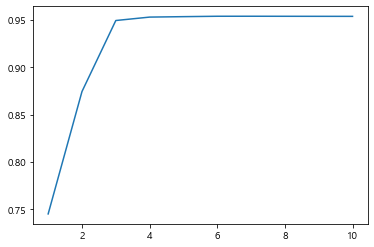

In [93]:
plt.plot(models_best['adj_r2'])
plt.show()

In [96]:
model_final = models_best.iloc[models_best['adj_r2'].argmax(),0]

In [97]:
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1183.
Date:                Fri, 21 May 2021   Prob (F-statistic):          3.50e-259
Time:                        23:11:52   Log-Likelihood:                -2400.0
No. Observations:                 400   AIC:                             4816.
Df Residuals:                     392   BIC:                             4848.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         -488.6159     25.289    -19.321      0.000    -538.335    -438.897
Gender[T.Female]   -10.4532      9.890     -1.057      0.291     -29.896       8.990
Student[T.Yes]     426.5813     16.533     25.802      0.000     394.077     459.085
Income              -7.8036      0.234    -33.417      0.000      -8.263      -7.345
Limit                0.1936      0.032      5.980      0.000       0.130       0.257
Rating               1.0940      0.485      2.257      0.025       0.141       2.047
Cards               18.1092      4.319      4.193      0.000       9.618      26.601
Age                 -0.6207      0.292     -2.127      0.034      -1.194      -0.047
==============================================================================
Omnibus:                       34.049   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.600
Skew:                           0.773   Prob(JB):                     1.53e-09
Kurtosis:                       3.211   Cond. No.                     2.72e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 6) Ridge & Lasso


### 6-1) Ridge
- 가중치들의 제곱합을 최소화하는 것을 제약조건으로 추가하는 기법
- 가중치의 모든 원소가 0에 가까워지는 것을 원한다. -> L2규제라고 한다.
- $\lambda $가 0이 되면 일반적인 선형회귀모델이 된다.

In [4]:
credit = pd.read_csv('Credit.csv').iloc[:,1:]

In [83]:
y, X = patsy.dmatrices('Balance~'+"+".join(credit.columns[:-1]), data = credit, return_type='dataframe')

In [11]:
ridge_reg = Ridge()
ridge_reg.fit(X,y)

Ridge()

In [12]:
y_pred = ridge_reg.predict(X)

In [17]:
pd.DataFrame(ridge_reg.coef_,columns=X.columns)

,Intercept,Gender[T.Female],Student[T.Yes],Married[T.Yes],Ethnicity[T.Asian],Ethnicity[T.Caucasian],Income,Limit,Rating,Cards,Age,Education
0,0.0,-10.153111,413.89986,-9.121554,16.772873,9.66826,-7.796138,0.188633,1.169353,17.495228,-0.622846,-1.007498


In [225]:
import warnings
warnings.filterwarnings('ignore')

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

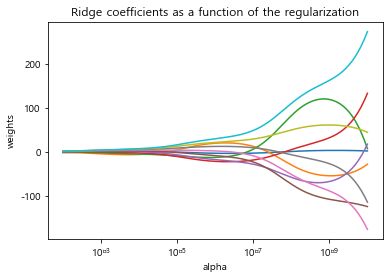

In [226]:
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### 6-2) Lasso

- 가중치 절대값의 합을 최소화하는 것을 제약조건으로 추가하는 기법
- 가중치가 0에 가까워질 뿐, 실제로 0이 되지 않는다. 그러나 중요하지 않은 가중치는 0이 될 수 있다.
- L1규제
- 변수 선택의 효과가 있다.

In [25]:
lasso_reg = Lasso(alpha=0.01)
lasso_reg.fit(X,y)
y_pred = lasso_reg.predict(X)

lasso_reg.coef_

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1893812.8720691514, tolerance: 8433.991191
  positive)


array([ 0.00000000e+00, -1.06082218e+01,  4.25689009e+02, -8.45041224e+00,
        1.66497454e+01,  9.99657462e+00, -7.80320873e+00,  1.91959216e-01,
        1.12083024e+00,  1.77952880e+01, -6.13858939e-01, -1.10161563e+00])

### 6-3) Elastic Net
- Ridge와 Lasso 절충한 모델
- 가중치의 절댓값 합과 제곱합을 동시에 제약조건을 가지는 모형으로 $\lambda_1$과 $\lambda_2$라는 2개의 하이퍼 모수를 가진다.

In [26]:
elasticnet = ElasticNet()
elasticnet.fit(X,y)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4520255.8592551295, tolerance: 8433.991191
  positive)


ElasticNet()

In [27]:
elasticnet.coef_

array([ 0.        ,  0.        , 63.01908588, -8.48979062,  5.45854586,
       -1.33355274, -7.59990254,  0.12005095,  2.15915532,  8.73219955,
       -0.85133737,  1.43532268])

## 7) Logistic Regression

In [31]:
default = pd.read_csv("Default.csv",index_col=0)

In [35]:
Default = pd.concat([default,pd.get_dummies(default.default,prefix="default")],axis=1)

In [45]:
model = smf.glm('default_Yes~balance', data=Default, family = sm.families.Binomial()).fit()
model.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


- balance의 회귀계수 p-value<0.0001 : 파산확률과 카드잔고 사이에 관계가 있음

In [39]:
np.exp(model.params[1])

1.0055140637295612

- balance가 1 증가하면 파산승산(odds)가 1.005514배 증가한다. 즉, 0.55% 증가한다.


In [40]:
np.exp(model.params[1]*100) ## 73.3% 증가

1.7330653054483087

In [41]:
1 - np.exp(-0.05) # 5%감소

0.048770575499285984

In [42]:
model2 = smf.glm('default_Yes~student', data=Default, family = sm.families.Binomial()).fit()
model2.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student[T.Yes],0.4049,0.115,3.520,0.000,0.179,0.630


In [43]:
np.exp(model2.params[1])

1.4991332099292414

- 학생이면 파산의 odds가 약 50% 증가한다.

In [46]:
model3 = smf.glm('default_Yes~balance + student', data=Default, family = sm.families.Binomial()).fit()
model3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.7495,0.369,-29.115,0.000,-11.473,-10.026
student[T.Yes],-0.7149,0.148,-4.846,0.000,-1.004,-0.426
balance,0.0057,0.000,24.748,0.000,0.005,0.006


In [47]:
np.exp(model3.params[1])

0.4892519822863293

- 동일한 balance를 가지고 있을 때 학생이면 파산 odds가 약 51% 감소한다.

### Mallow's CP
- 최소자승법을 사용하여 추정된 회귀모형의 적합성 평가에 사용
- Cp값이 작으며 p+상수(변수의 개수 + 상수)에 가까운 모형을 선택
- Cp값이 p와 비슷한 경우 : 편향이 작고 우수한 모델
- Cp값이 p보다 큰 경우 : 편향이 크고 추가적인 변수가 필요한 모델을 의미
- Cp값이 p보다 작은 경우 : 분산의 증가폭보다 편향의 감소폭이 더 크며 필요 없는 변- 수가 모델에 있다는 것을 의미

In [ ]:
cp_list = []
variables = []
cnt_variable = []
sst = np.sum(np.square((cars.Price - np.mean(cars.Price))))
for n in range(1, len(columns)) :
    
    for c in combinations(columns, n) :
        exp = '+'.join(c)
        ols_exp = 'Price ~ ' + exp
        model = ols(ols_exp, data = cars)
        result = model.fit()
        mse = result.mse_resid
        sse = np.sum(np.square(result.resid))
        cp = sse / mse - (cars.shape[0] - 2 * (len(model.exog_names) + 1))
        cp_list.append(cp)
        variables.append(c)
        cnt_variable.append(len(c))

In [ ]:
cp_df = pd.DataFrame({'num_of_variables' : cnt_variable, 'variable' : variables, 'Cp' : cp_list})
cp_df.sort_values(by = 'Cp', ascending = False)[:10]

- CP값이 작으며 p+상수인 5에 가까우므로 적합한 모형이라고 할 수 있다.

- 변수선택시 for 문을 활용하면 적합한 모델 탐색을 할 수 있다.

## 진행방법

- 이상치 및 결측값 확인
- 상관관계 및 데이터 value_counts를 통해 확인(0이 많은 칼럼 버리기, 상관관계가 너무 높거나 낮은것들 버리기)
- 왜도 확인해서 정규성 만들어주기(boxcox,log)
- 회귀분석 진행
- 다중공선성이 높으면 -> 정규화, 다중공선성 높은 데이터 제거 등
- 잔차 분석 후 선형성을 띄고 잇으면 log, 제곱, 루트 등 진행